#### GMM (Gaussian Mixture Model)
GMM is a model that allows soft clustering (getting a probability of belonging to each class). The intuition behind the algorithm is as follows: we assume multiple Gaussians that contain points from the dataset and then we calculate how much percentage of each data point is attributed to what cluster by calculating $PDF(X)$ on each Gaussian:
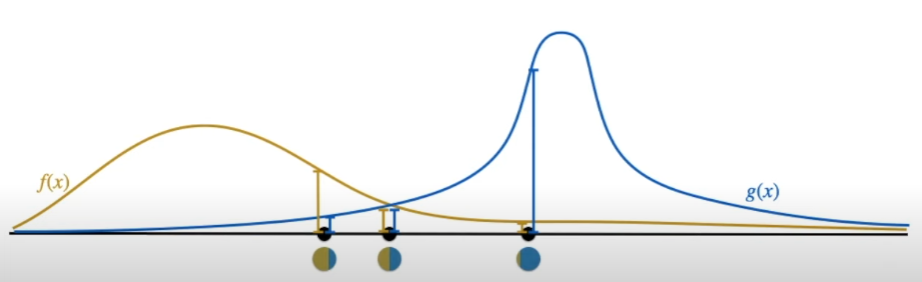

#### When to use?
When it is hard to cluster data distinctevely, meaning that there could be intersections between clusters:
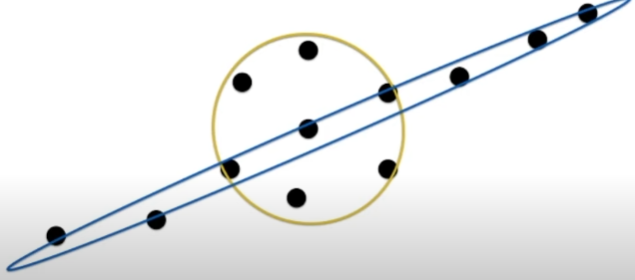

#### Algorithm
The GMM algorithm can be described in following steps:
- Start with random Multivariate Gaussians (https://en.wikipedia.org/wiki/Multivariate_normal_distribution)
- While some condition (e.g. there's still divergence between previous gaussians and current ones):
    - "Color" points (assign percentages of clusters) according to these Gaussians
    - Given percentages of each data assigned based on Gaussians, recalculate these Gaussians to better fit colored data. In each group of "truncated" points we will find $\mu$ and calculate the covariance matrix $\sum$. Now we will recalculate the Gaussian by $\frac{exp(-\frac{1}{2}(X-\mu)^T\sum^{-1}(X-\mu))}{2\pi\sqrt{|\sum|}}$

#### Convergence calculation example
In practice we can check whether we've reached convergence between gaussians by comparing L1-norm of differences between current prior probability and the previous one with some tolerance scalar value.

Now we can finally build custom implementation of the GMM.

In [12]:
import numpy as np

def cov_matrix(X, Y=None):
    if Y is None:
        Y = X
    n_samples = X.shape[0]
    covariance_matrix = (1 / (n_samples-1)) \
        * (X - X.mean(axis=0)).T.dot(Y - Y.mean(axis=0))
    return np.array(covariance_matrix, dtype=float)

In [53]:
from tqdm import tqdm
import matplotlib.pyplot as plt

class GMM():

    def __init__(self, k=2, max_iter=2000, tol=1e-8):
        self.k = k # number of gaussians
        self.max_iter = max_iter # max number of loop iterations
        self.tol = tol # tolerance value for convergence check
        self.posteriors = [] # records of posteriors P(params|X) over iterations
        self.pred = None # predicted clusters' indices
        self.posterior = None # latest P(params|X)
        self.prior = None # latest P(params), that we put in Bayes formula
        self.params = [] # params of each gaussian over iterations

    def _init_random_gauss(self, X):
        """
        Init random Gaussians
        """
        N = X.shape[0]
        # initially we assume that the distribution of all K clusters is uniform
        self.prior = (1/self.k)*np.ones(self.k)
        for i in range(self.k):
            self.params.append(
                {'mean': X[np.random.randint(0,N-1)],
                 'cov': cov_matrix(X)}
            )
    
    def _multivar_gauss_pdf(self, X, params):
        """
        Method that for each sample in X
        calculates the corresponding probability
        on the PDF of some multivariate Gaussian
        """
        N, D = X.shape
        mu = params['mean']
        cov = params['cov']
        det = np.linalg.det(cov)
        likelihoods = np.zeros(N) # P(X|params)
        for i, sample in enumerate(X):
            pdf = (2*np.pi)**(-D/2) * det**(-.5) * \
                np.exp(
                    -.5 * (sample-mu).T @ np.linalg.pinv(cov) @ (sample-mu)
                ) # PDF of multivariate Gaussian
            likelihoods[i] = pdf
        return likelihoods
    
    def _get_likelihoods(self, X):
        """
        For each Gaussian from i=1 to K calculate
        likelihoods for each sample
        """
        N = X.shape[0]
        tot_likelihoods = np.zeros((N,self.k))
        for i in range(self.k):
            tot_likelihoods[:,i] = \
                self._multivar_gauss_pdf(X,self.params[i])
        return tot_likelihoods
    
    def _calc_posteriors(self, X):
        """
        Calculating posteriors P(params|X)
        """
        numerator = self._get_likelihoods(X) * self.prior

        # since our function field is clipped by K unique
        # parameter values, we could calculate P(X) by
        # just simply summing over all likelihoods
        denominator = numerator.sum(axis=1).reshape(-1, 1)

        # all posteriors over samples over K Gaussians
        self.posterior = numerator / denominator 
        self.pred = self.posterior.argmax(axis=1)

        # recording the posterior of the most accurate prediction
        self.posteriors.append(np.max(self.posterior, axis=1))

    def _update(self, X):
        """ 
        Updating parameters of Gaussians and the dist of priors
        """
        N = X.shape[0]
        for i in range(self.k):
            posteriors = self.posterior[:, i].reshape(-1, 1)

            # posteriors in our case indicate the fraction of
            # the data from the sample that is contained within the gaussian
            # since our distribution is clipped by K
            jointDist = posteriors * X
            mu = jointDist.sum(axis=0) / posteriors.sum()
            cov = (X-mu).T.dot((X-mu) * posteriors) / posteriors.sum()
            self.params[i]['mean'], self.params[i]['cov'] = \
                mu, cov
            
        # summing over all gaussians and dividing sum of
        # fractions of data points by all data points
        self.prior = self.posterior.sum(axis=0) / N

    def _is_converged(self):
        """
        Implementing the L1-norm convergence rule described above
        """
        if len(self.posteriors) < 2: return False
        l1Norm = np.linalg.norm(
            self.posteriors[-1]-self.posteriors[-2], ord=1)
        return l1Norm <= self.tol
    
    def predict(self, X):
        self._init_random_gauss(X)

        for _ in tqdm(range(self.max_iter)):
            self._calc_posteriors(X)
            self._update(X)

            if self._is_converged():
                print('Convergence reached before the end!')
                break

        # calculate posteriors on the latest updated params
        # and return predicted clusters
        self._calc_posteriors(X) 
        return self.pred
    
X = np.array([[1, 2], [1, 4], [1, 0], [10, 2], [10, 4], [10, 0]])
customGmm = GMM(k=3)
customGmm.predict(X)

  0%|          | 1/2000 [00:00<00:03, 500.27it/s]

Convergence reached before the end!


array([0, 0, 0, 0, 0, 0], dtype=int64)

Although some predictions match the GMM implementation in scikit-learn, there are some mismatches, that might have happened because of the uninformative uniform prior. Also, another, more advanced convergence rule might be needed in order to improve predictions

In [33]:
from sklearn.mixture import GaussianMixture
sklearnGmm = GaussianMixture(n_components=3, random_state=0).fit_predict(X)
sklearnGmm

array([1, 2, 1, 0, 0, 0], dtype=int64)